***POTATO DISEASE CLASSIFICATION***
downloaded dataset from :https://www.kaggle.com/datasets/arjuntejaswi/plant-village

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

**Set all the constants**

In [80]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

**Importing data into tensorflow dataset object**

In [25]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "pdclassification", 
    shuffle=True, 
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [26]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [27]:
len(dataset)

68

In [78]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1]


**Visualizing Some of the images from our dataset**

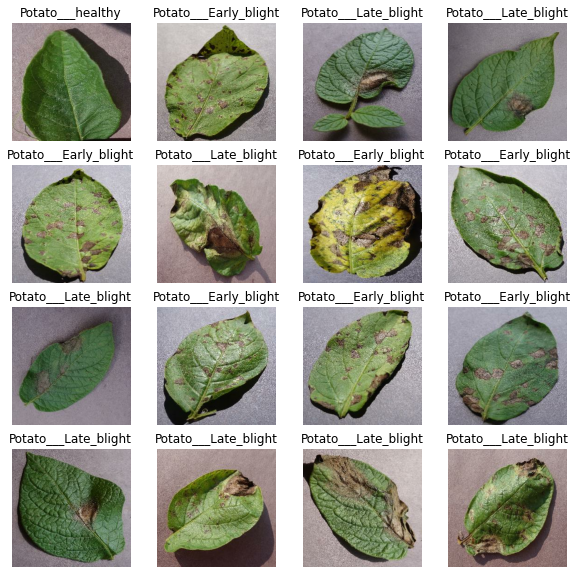

In [71]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        

**Function to Split Dataset:**     
Dataset should be splitted into 3 subsets:

Training: Dataset to be used while training  
Validation: Dataset to be tested against while training  
Test: Dataset to be tested against after we trained a model  

In [30]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [31]:
train_ds=dataset.take(54)
len(train_ds)

54

In [32]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [33]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [34]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [35]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [36]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds ,test_ds

In [37]:
train_ds,val_ds,test_ds = get_dataset_partition_tf(dataset)
len(train_ds)

54

In [38]:
len(val_ds)

6

In [39]:
len(test_ds)

8

**Cache,Shuffle,Prefetch the dataset**

In [40]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Building the Model**  
Creating a Layer for Resizing and normalization                               
Resize images to the desired size and normalize pixel values to the 0-1 range by dividing by 256. Apply these steps during both training and inference by adding them as layers in the Sequential Model.                   
We resize a (256,256) image to (256,256) to handle future predictions. This ensures any non-(256,256) input image is resized correctly during model use.


In [41]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

**Data Augmentation**       
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [42]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

**Model Archetecture**  

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [43]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

**Compiling the Model**

In [44]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [45]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
54/54 [==============================] - 186s 3s/step - loss: 0.8546 - accuracy: 0.5637 - val_loss: 0.6892 - val_accuracy: 0.7188
Epoch 2/20
54/54 [==============================] - 165s 3s/step - loss: 0.5398 - accuracy: 0.7784 - val_loss: 0.3781 - val_accuracy: 0.8542
Epoch 3/20
54/54 [==============================] - 165s 3s/step - loss: 0.3226 - accuracy: 0.8669 - val_loss: 0.3031 - val_accuracy: 0.8750
Epoch 4/20
54/54 [==============================] - 168s 3s/step - loss: 0.2936 - accuracy: 0.8895 - val_loss: 0.2366 - val_accuracy: 0.9115
Epoch 5/20
54/54 [==============================] - 167s 3s/step - loss: 0.2377 - accuracy: 0.9120 - val_loss: 0.1914 - val_accuracy: 0.9271
Epoch 6/20
54/54 [==============================] - 166s 3s/step - loss: 0.2080 - accuracy: 0.9178 - val_loss: 0.1558 - val_accuracy: 0.9375
Epoch 7/20
54/54 [==============================] - 165s 3s/step - loss: 0.1607 - accuracy: 0.9352 - val_loss: 0.2687 - val_accuracy: 0.8958
Epoch 8/20
54

In [46]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 6s 355ms/step - loss: 0.1453 - accuracy: 0.9570


In [47]:
scores

[0.14527995884418488, 0.95703125]

In [48]:
history

In [49]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [50]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Plotting the Accuracy and Loss Curves**

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

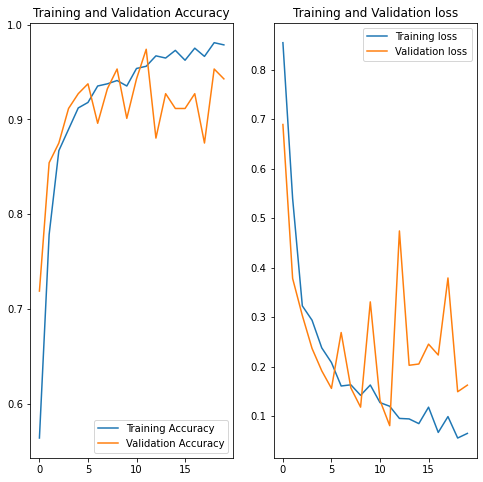

In [54]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

**Run prediction on a sample image**

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 390ms/step
predicted label: Potato___Late_blight


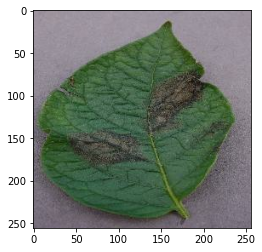

In [59]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Writing a function for inference**

In [72]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 47ms/step


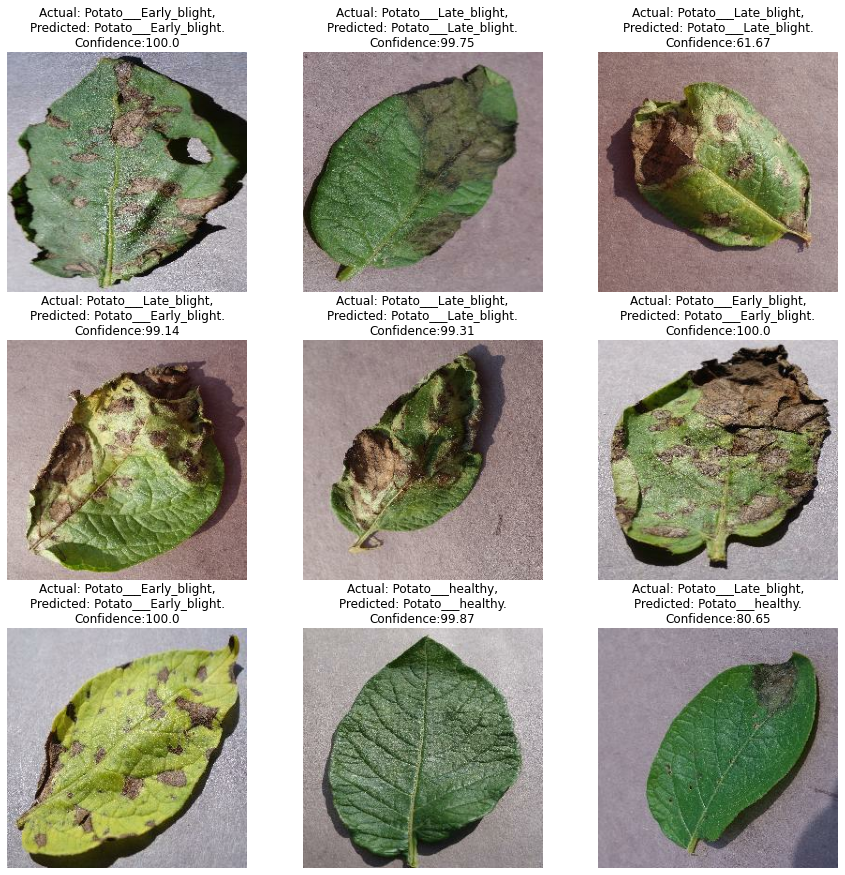

In [73]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence:{confidence}")
        plt.axis("off")

**Saving the Model**

In [69]:
model_version=1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets
